In [5]:
!pip install torch

  Using cached torch-2.1.1-cp310-none-macosx_11_0_arm64.whl.metadata (25 kB)
  Using cached filelock-3.13.1-py3-none-any.whl.metadata (2.8 kB)
  Using cached sympy-1.12-py3-none-any.whl (5.7 MB)
  Using cached networkx-3.2.1-py3-none-any.whl.metadata (5.2 kB)
  Using cached fsspec-2023.12.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
Using cached torch-2.1.1-cp310-none-macosx_11_0_arm64.whl (59.6 MB)
Using cached filelock-3.13.1-py3-none-any.whl (11 kB)
Using cached fsspec-2023.12.1-py3-none-any.whl (168 kB)
Using cached networkx-3.2.1-py3-none-any.whl (1.6 MB)


In [6]:
!pip install torchvision

  Using cached torchvision-0.16.1-cp310-cp310-macosx_11_0_arm64.whl.metadata (6.6 kB)
Using cached torchvision-0.16.1-cp310-cp310-macosx_11_0_arm64.whl (1.5 MB)


In [1]:

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn.functional as F
import torchvision.transforms as transforms

from sklearn.metrics.pairwise import polynomial_kernel, rbf_kernel
from scipy.linalg import svd
import numpy as np
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import center_of_mass
from math import sqrt, inf, floor

In [2]:
## Fisheye Transformation
def get_of_fisheye(height, width, center, magnitude):
  xx, yy = torch.linspace(-1, 1, width), torch.linspace(-1, 1, height)
  gridy, gridx  = torch.meshgrid(yy, xx)   #create identity grid
  grid = torch.stack([gridx, gridy], dim=-1)
  d = center - grid         #calculate the distance(cx - x, cy - y) 
  d_sum = torch.sqrt((d**2).sum(axis=-1)) # sqrt((cx-x)**2 + (cy-y)**2)
  grid += d * d_sum.unsqueeze(-1) * magnitude #calculate dx & dy and add to original values
  return grid.unsqueeze(0)    #unsqueeze(0) since the grid needs to be 4D.

## Horizontal Wave Transformation
def get_of_horizontalwave(height, width, freq, amplitude):
  xx, yy = torch.linspace(-1, 1, width), torch.linspace(-1, 1, height)
  gridy, gridx = torch.meshgrid(yy, xx) #create identity grid
  grid = torch.stack([gridx, gridy], dim=-1)
  dy = amplitude * torch.cos(freq * grid[:,:,0]) #calculate dy
  grid[:,:,1] += dy
  return grid.unsqueeze(0)  #unsqueeze(0) since the grid needs to be 4D.


def plot(img, fisheye_output, hwave_output):
  fisheye_out = fisheye_output[0].numpy()
  fisheye_out = np.moveaxis(fisheye_out, 0,-1)

  hwave_out = hwave_output[0].numpy()
  hwave_out = np.moveaxis(hwave_out, 0,-1)

  fig, ax = plt.subplots(1,3, figsize=(16,4))
  ax[0].imshow(img)
  ax[1].imshow(fisheye_out)
  ax[2].imshow(hwave_out)

  ax[0].set_title('Input Image(Checkerboard)')
  ax[1].set_title('Fisheye')
  ax[2].set_title('Horizontal Wave Tfms')
  plt.show()

In [3]:
(images, labels), (_, _) = mnist.load_data()
images.shape

flattened_images = images.reshape(images.shape[0], -1)

In [6]:
fisheye_grid = get_of_fisheye(28, 28, torch.tensor([14, 14]), 0.4)
hwave_grid = get_of_horizontalwave(28, 28, 10, 0.1)

fisheye_output = F.grid_sample(torch.tensor(images), fisheye_grid, align_corners=True)
hwave_output = F.grid_sample(torch.tensor(images), hwave_grid, align_corners=True)
plot(img, fisheye_output, hwave_output)

RuntimeError: grid_sampler(): expected grid and input to have same batch size, but got input with sizes [60000, 28, 28] and grid with sizes [1, 28, 28, 2]

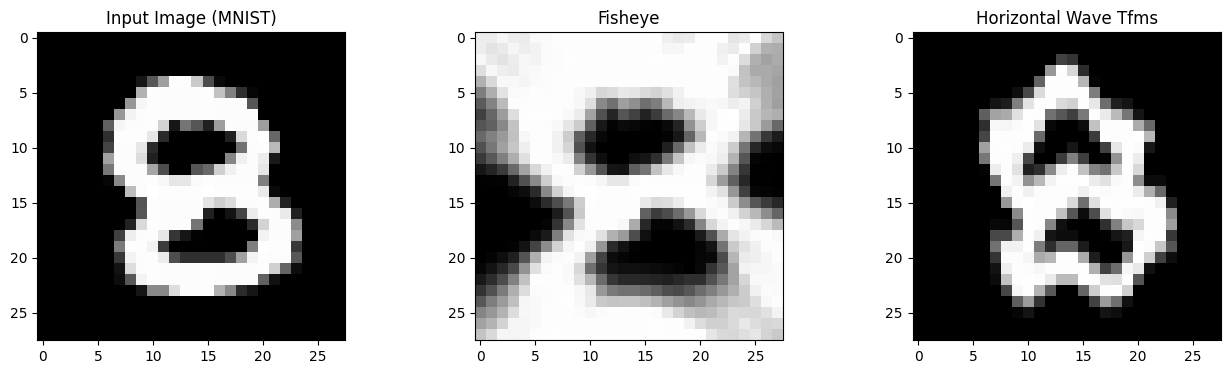

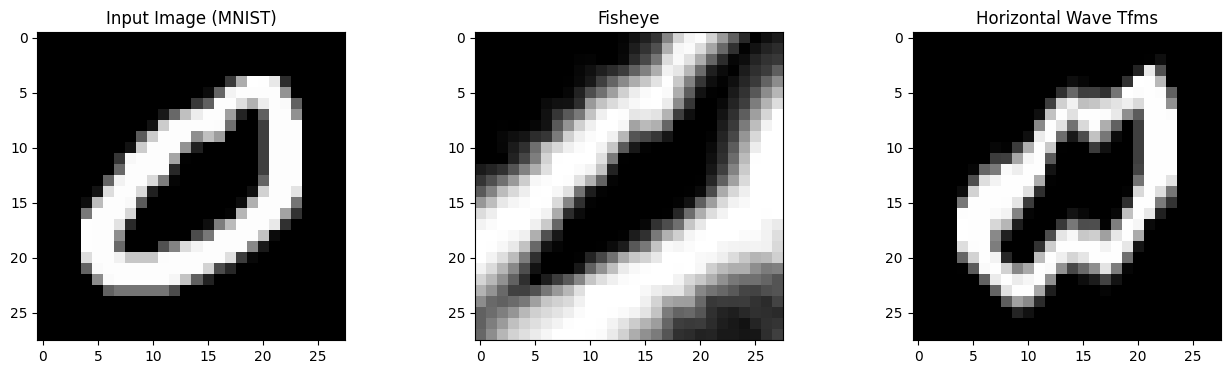

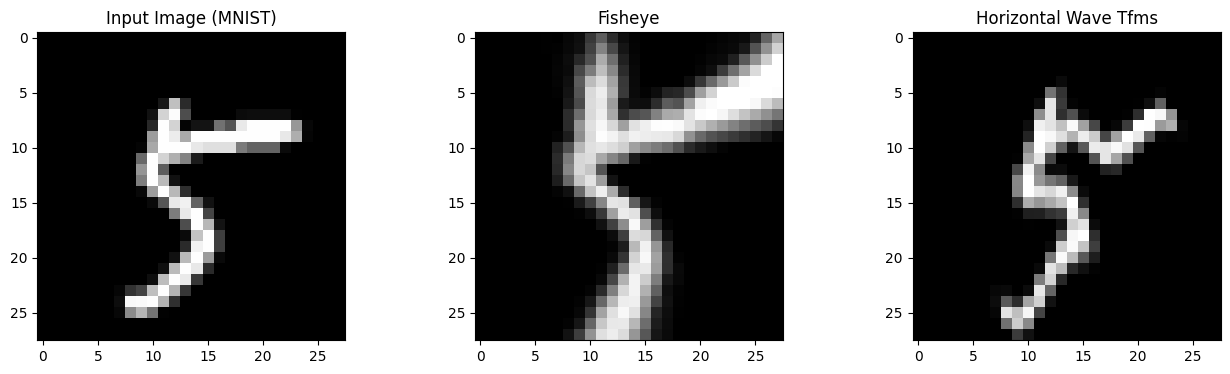

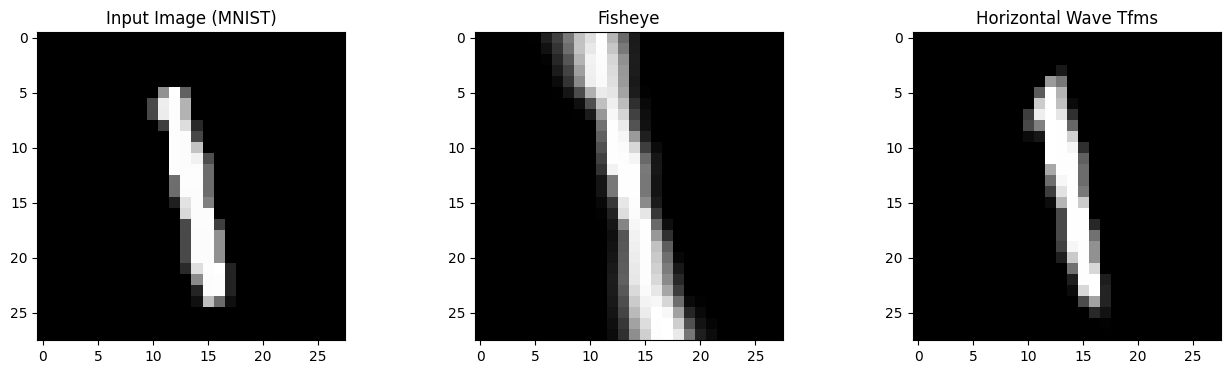

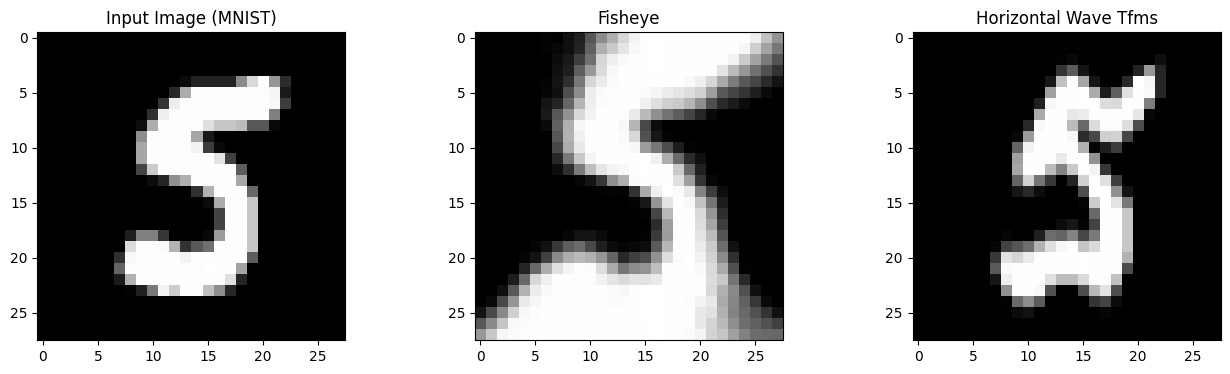

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets

# Fisheye Transformation
def get_of_fisheye(height, width, center, magnitude):
    xx, yy = torch.linspace(-1, 1, width), torch.linspace(-1, 1, height)
    gridy, gridx = torch.meshgrid(yy, xx)   # create identity grid
    grid = torch.stack([gridx, gridy], dim=-1)
    d = center - grid         # calculate the distance(cx - x, cy - y) 
    d_sum = torch.sqrt((d**2).sum(axis=-1)) # sqrt((cx-x)**2 + (cy-y)**2)
    grid += d * d_sum.unsqueeze(-1) * magnitude # calculate dx & dy and add to original values
    return grid.unsqueeze(0)    # unsqueeze(0) since the grid needs to be 4D.

# Horizontal Wave Transformation
def get_of_horizontalwave(height, width, freq, amplitude):
    xx, yy = torch.linspace(-1, 1, width), torch.linspace(-1, 1, height)
    gridy, gridx = torch.meshgrid(yy, xx) # create identity grid
    grid = torch.stack([gridx, gridy], dim=-1)
    dy = amplitude * torch.cos(freq * grid[:,:,0]) # calculate dy
    grid[:,:,1] += dy
    return grid.unsqueeze(0)  # unsqueeze(0) since the grid needs to be 4D.

# Utility Functions
# Create Image Batch
def get_image_batch(img):
    transform = transforms.Compose([transforms.ToTensor()])
    tfms_img = transform(img)
    imgs = torch.unsqueeze(tfms_img, dim=0)
    return imgs

# Plotting Function
def plot(img, fisheye_output):
    fisheye_out = fisheye_output[0].numpy()
    fisheye_out = np.moveaxis(fisheye_out, 0, -1)

    fig, ax = plt.subplots(1, 3, figsize=(16, 4))
    ax[0].imshow(img, cmap='gray')
    ax[1].imshow(fisheye_out, cmap='gray')
    ax[2].imshow(hwave_out, cmap='gray')

    ax[0].set_title('Input Image (MNIST)')
    ax[1].set_title('Fisheye')
    ax[2].set_title('Horizontal Wave Tfms')
    plt.show()

# Download MNIST dataset
mnist_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
mnist_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=1, shuffle=True)

# Get fisheye and horizontal wave grids
H, W = 28, 28
fisheye_grid = get_of_fisheye(H, W, torch.tensor([0, 0]), 0.4)
hwave_grid = get_of_horizontalwave(H, W, 10, 0.1)

# Apply transformations to each image in the MNIST dataset
count = 0
for img, _ in mnist_loader:
    fisheye_output = F.grid_sample(img, fisheye_grid, align_corners=True)
    # hwave_output = F.grid_sample(img, hwave_grid, align_corners=True)
    plot(img.squeeze().numpy(), fisheye_output, hwave_output)
    count += 1
    if count == 5:
        break
